In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, when, avg, count, to_date
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
# Initializing the Spark session
spark = SparkSession.builder.appName("CustomerFeedbackAnalysis").getOrCreate()

In [30]:
feedback_df = spark.read.csv("C:\\Users\\jpabb\\Downloads\\feedback_data.csv", header=True, inferSchema=True)

In [31]:
# 1. Data Cleaning
spark = SparkSession.builder \
    .appName("Feedback Data Cleaning") \
    .getOrCreate()


feedback_df = feedback_df.filter(
    col("Customer ID").isNotNull() & 
    col("Feedback Channel").isNotNull() & 
    col("Rating").isNotNull() & 
    col("Comment").isNotNull() & 
    col("Date").isNotNull()
)
feedback_df = feedback_df.withColumn(
    "Comment", 
    regexp_replace(col("Comment"), "[^a-zA-Z0-9\s'.]", "")  
)

feedback_df = feedback_df.withColumn(
    "Date", 
    to_date(col("Date"), "yyyy-MM-dd")
)

feedback_df.show()


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jpabb\AppData\Local\Temp\ipykernel_10524\2217399004.py:16: SyntaxWarning: invalid escape sequence '\s'
  regexp_replace(col("Comment"), "[^a-zA-Z0-9\s'.]", "")


+-----------+----------------+------+--------------------+----------+
|Customer ID|Feedback Channel|Rating|             Comment|      Date|
+-----------+----------------+------+--------------------+----------+
|   CUST1003|           Email|   5.0|   Needs improvement|2024-01-09|
|   CUST1004|       In-Person|   1.0|     Could be better|2023-11-14|
|   CUST1005|         Website|   2.0|Not happy with th...|2024-09-14|
|   CUST1006|           Email|   3.0|        Disappointed|2024-06-23|
|   CUST1008|           Email|   5.0|Not happy with th...|2024-01-15|
|   CUST1009|           Phone|   1.0|Excellent experience|2024-09-26|
|   CUST1010|           Phone|   4.0|            Loved it|2024-05-03|
|   CUST1011|           Phone|   2.0|            Loved it|2023-12-10|
|   CUST1012|           Email|   2.0|     Had some issues|2024-08-14|
|   CUST1013|         Website|   5.0|Not happy with th...|2024-10-08|
|   CUST1014|           Phone|   3.0|      Very satisfied|2024-07-20|
|   CUST1015|       

In [32]:
tokenizer = Tokenizer(inputCol="Comment", outputCol="tokens")

stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer])
model = pipeline.fit(feedback_df) 
transformed_df = model.transform(feedback_df)
transformed_df.select("Comment", "tokens", "filtered_tokens", "features").show(truncate=False)


+---------------------------+---------------------------------+-----------------------+----------------------+
|Comment                    |tokens                           |filtered_tokens        |features              |
+---------------------------+---------------------------------+-----------------------+----------------------+
|Needs improvement          |[needs, improvement]             |[needs, improvement]   |(17,[9,10],[1.0,1.0]) |
|Could be better            |[could, be, better]              |[better]               |(17,[16],[1.0])       |
|Not happy with the response|[not, happy, with, the, response]|[happy, response]      |(17,[2,3],[1.0,1.0])  |
|Disappointed               |[disappointed]                   |[disappointed]         |(17,[8],[1.0])        |
|Not happy with the response|[not, happy, with, the, response]|[happy, response]      |(17,[2,3],[1.0,1.0])  |
|Excellent experience       |[excellent, experience]          |[excellent, experience]|(17,[12,13],[1.0,1.0])|
|

In [33]:
# 3. Sentiment Analysis (positive if rating > 3, orelse negative/neutral)
feedback_df = feedback_df.withColumn("sentiment",
                                     when(col("Rating").isin(4, 5), "positive")
                                     .when(col("Rating") == 3, "neutral")
                                     .otherwise("negative"))

In [34]:
# 4. Trend Analysis

avg_ratings = feedback_df.groupBy("Feedback Channel").agg(F.avg("Rating").alias("Average_Rating"))
channel_counts = feedback_df.groupBy("Feedback Channel", "sentiment").count()


In [35]:
# 5. Data Visualization
avg_ratings.show()
channel_counts.show()
feedback_df.groupBy("Feedback Channel", "sentiment").count().show()

+----------------+------------------+
|Feedback Channel|    Average_Rating|
+----------------+------------------+
|           Phone| 2.959537572254335|
|           Email|3.1508379888268156|
|         Website|2.9553072625698324|
|       In-Person| 3.058201058201058|
+----------------+------------------+

+----------------+---------+-----+
|Feedback Channel|sentiment|count|
+----------------+---------+-----+
|       In-Person| positive|   84|
|       In-Person| negative|   78|
|           Phone| positive|   63|
|           Email| negative|   68|
|           Email|  neutral|   31|
|           Phone| negative|   64|
|           Email| positive|   80|
|           Phone|  neutral|   46|
|       In-Person|  neutral|   27|
|         Website| positive|   69|
|         Website| negative|   80|
|         Website|  neutral|   30|
+----------------+---------+-----+

+----------------+---------+-----+
|Feedback Channel|sentiment|count|
+----------------+---------+-----+
|       In-Person| positive| 

In [36]:
# Converting Spark DataFrames to Pandas for Visualization
avg_ratings_pd = avg_ratings.toPandas()
channel_counts_pd = channel_counts.toPandas()


C:\Users\jpabb\AppData\Local\Temp\ipykernel_10524\451156215.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feedback_df.toPandas(), x="Feedback Channel", y="Rating", palette="viridis")


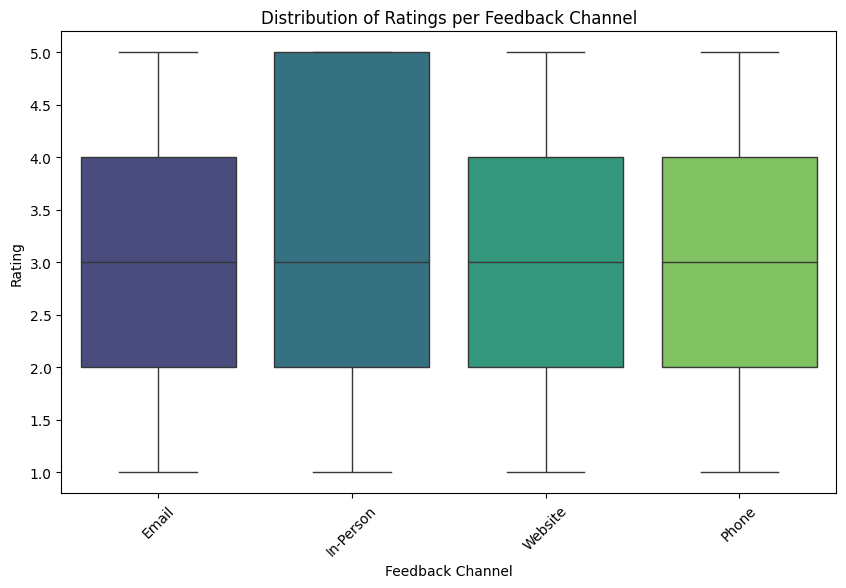

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=feedback_df.toPandas(), x="Feedback Channel", y="Rating", palette="viridis")
plt.title("Distribution of Ratings per Feedback Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.show()


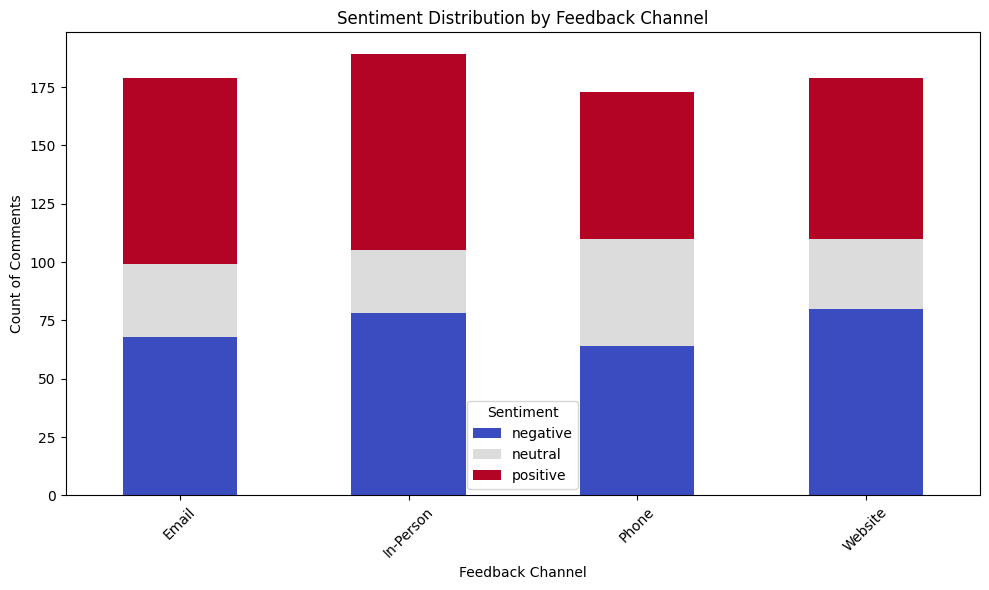

In [38]:
channel_counts_pivot = channel_counts_pd.pivot_table(index='Feedback Channel', columns='sentiment', values='count', fill_value=0)

plt.figure(figsize=(10, 6))
channel_counts_pivot.plot(kind='bar', stacked=True, colormap='coolwarm', ax=plt.gca())
plt.title("Sentiment Distribution by Feedback Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Count of Comments")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
trend_data = (feedback_df
               .groupBy("Date", "sentiment")
               .agg(F.count("*").alias("Count"))
               .orderBy("Date"))

trend_data_pd = trend_data.toPandas()
trend_data_pd["Date"] = pd.to_datetime(trend_data_pd["Date"])


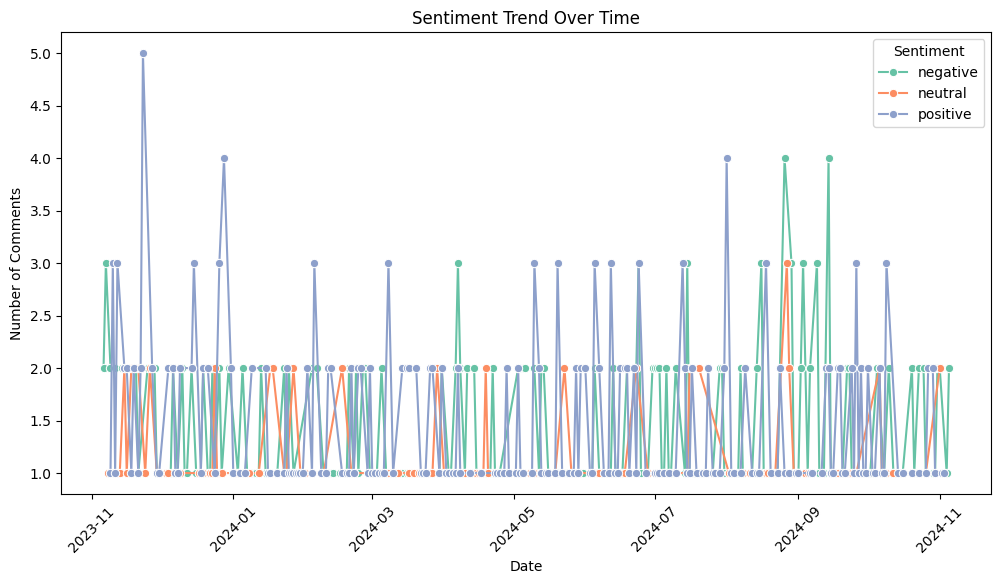

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data_pd, x="Date", y="Count", hue="sentiment", marker="o", palette="Set2")
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.legend(title="Sentiment")
plt.xticks(rotation=45) 
plt.show()


In [44]:
overall_sentiment_counts = channel_counts_pd.groupby("sentiment")["count"].sum()


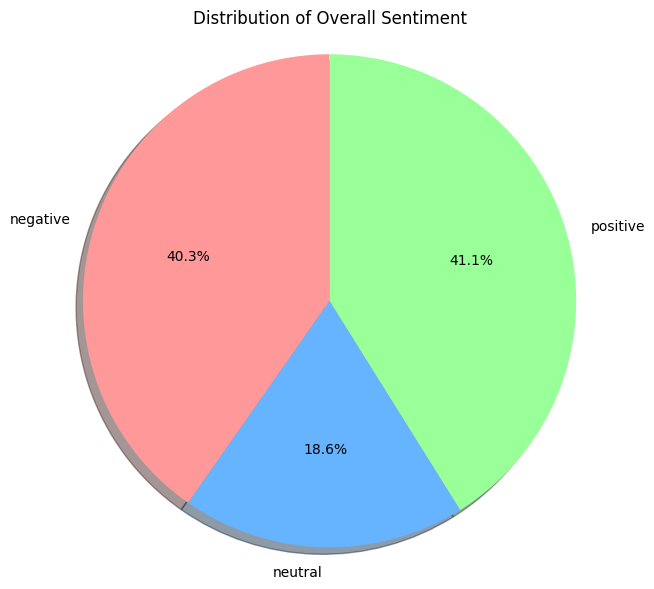

In [46]:
plt.figure(figsize=(7, 7))
plt.pie(overall_sentiment_counts, labels=overall_sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=["#ff9999", "#66b3ff", "#99ff99"], shadow=True)
plt.title("Distribution of Overall Sentiment")
plt.axis('equal')
plt.show()


In [47]:

spark.stop()
